In [1]:
import os
import pandas as pd


In [3]:
# paths to your folders
pr_path = "C:/Users/mahit/Downloads/Ass/PR"
ghi_path = "C:/Users/mahit/Downloads/Ass/GHI"

all_data = []

# assuming both PR and GHI have the same structure and same file names
for pr_subfolder, ghi_subfolder in zip(sorted(os.listdir(pr_path)), sorted(os.listdir(ghi_path))):
    pr_subfolder_path = os.path.join(pr_path, pr_subfolder)
    ghi_subfolder_path = os.path.join(ghi_path, ghi_subfolder)

    # read all CSV files inside each subfolder
    pr_files = sorted(os.listdir(pr_subfolder_path))
    ghi_files = sorted(os.listdir(ghi_subfolder_path))

    for pr_file, ghi_file in zip(pr_files, ghi_files):
        pr_df = pd.read_csv(os.path.join(pr_subfolder_path, pr_file))
        ghi_df = pd.read_csv(os.path.join(ghi_subfolder_path, ghi_file))

        # merge on Date
        merged = pd.merge(pr_df, ghi_df, on="Date", how="inner")

        # rename columns properly
        merged.columns = ["Date", "PR", "GHI"]

        all_data.append(merged)

# concatenate everything into a single dataframe
final_df = pd.concat(all_data, ignore_index=True)

# save to CSV
final_df.to_csv("final_output.csv", index=False)

print("✅ Final CSV created: final_output.csv")

✅ Final CSV created: final_output.csv


In [4]:
final_df

,Date,PR,GHI
0,2019-07-01,69.575676,3.256608
1,2019-07-02,79.314411,3.976767
2,2019-07-03,61.020006,2.811867
3,2019-07-04,83.262576,3.658408
4,2019-07-05,82.124440,5.590683
...,...,...,...
977,2022-03-20,81.632738,4.226183
978,2022-03-21,71.057353,3.431675
979,2022-03-22,81.631509,3.580492
980,2022-03-23,71.906149,4.997617


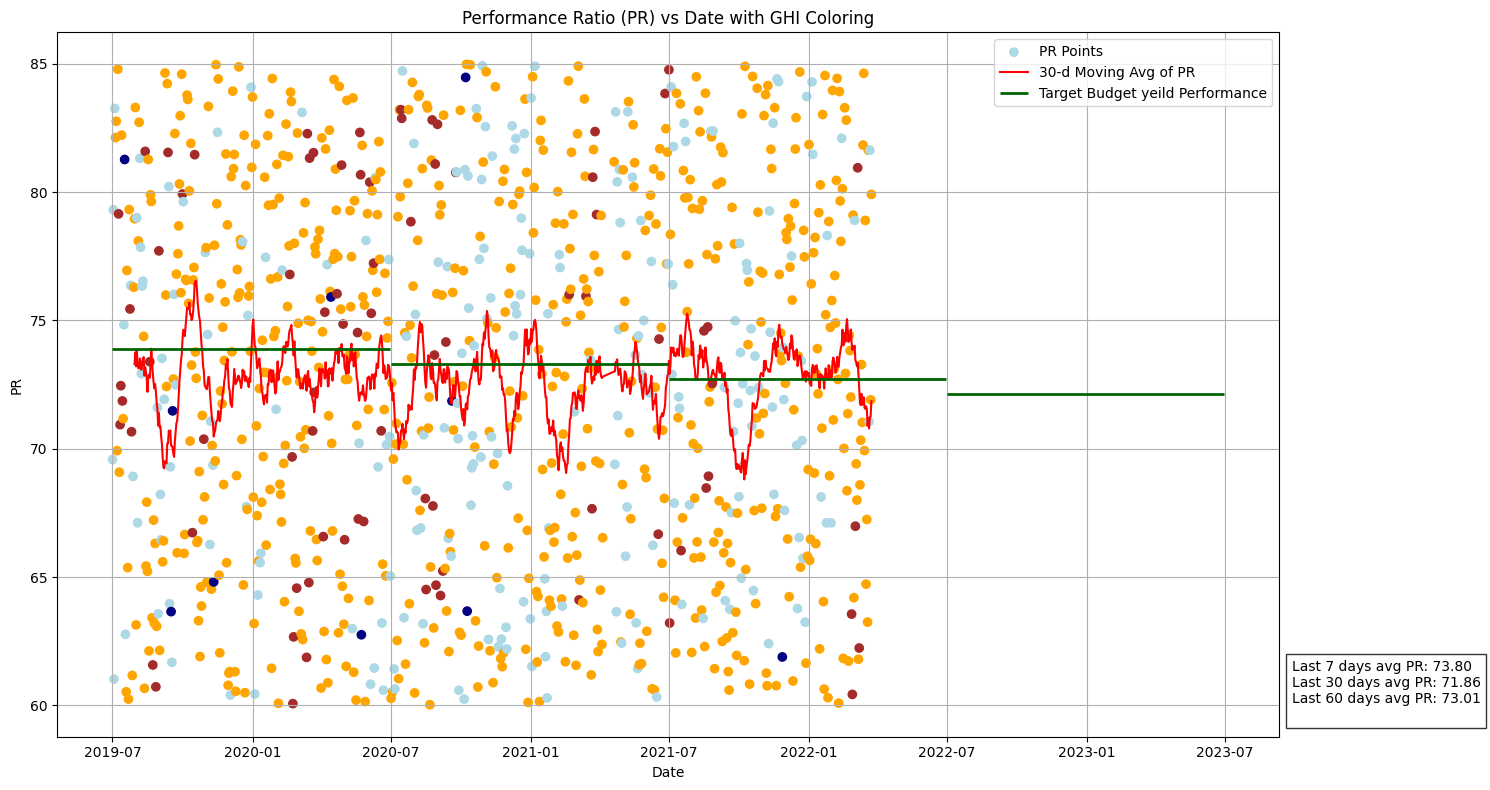

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

def plot_pr_graph(df, start_date=None, end_date=None):
    # Filter by date range if provided
    if start_date and end_date:
        mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
        df = df.loc[mask]

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    # Calculate 30-day rolling average
    df['PR_MA30'] = df['PR'].rolling(window=30).mean()

    # ---- Budget Line Calculation ----
    budget_start = 73.9
    budget_df = []
    start = dt.datetime(2019, 7, 1)

    for i in range(4):  # 4 years example
        end = start + pd.DateOffset(years=1) - pd.DateOffset(days=1)
        value = budget_start * ((1 - 0.008) ** i)  # reduce 0.8% per year
        budget_df.append((start, end, value))
        start = start + pd.DateOffset(years=1)

    # Scatter color based on GHI
    def color_map(ghi):
        if ghi < 2: return "navy"
        elif ghi < 4: return "lightblue"
        elif ghi < 6: return "orange"
        else: return "brown"

    colors = df['GHI'].apply(color_map)

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Scatter plot of PR
    ax.scatter(df['Date'], df['PR'], c=colors, label="PR Points")

    # Rolling average (red line)
    ax.plot(df['Date'], df['PR_MA30'], color='red', label='30-d Moving Avg of PR')

    # Budget line (dark green)
    for (start, end, value) in budget_df:
        ax.hlines(y=value, xmin=start, xmax=end, color='darkgreen', linewidth=2, label="Target Budget yeild Performance" if start.year==2019 else "")

    # ---- Add Summary Box ----
    summary_text = ""
    for window in [7, 30, 60]:
        avg_value = df['PR'].tail(window).mean()
        summary_text += f"Last {window} days avg PR: {avg_value:.2f}\n"

    # Place text box at bottom right
    ax.text(
        1.01, 0.02, summary_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='bottom',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
    )

    # Labels & formatting
    ax.set_title("Performance Ratio (PR) vs Date with GHI Coloring")
    ax.set_xlabel("Date")
    ax.set_ylabel("PR")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

plot_pr_graph(final_df, start_date="2019-07-01", end_date="2022-03-24")